# Import Packages

In [3]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

2025-05-07 21:48:31.638305: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 21:48:31.744373: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 21:48:31.858063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746668911.976672 1743142 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746668912.015186 1743142 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746668912.218157 1743142 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Load the simulation data

In [4]:
# Load EIS data-set
# filename : part of the simulation data

filename="EISmat/xy_data_32k_5circuit_v2_test_set.mat"

x=scipy.io.loadmat(filename)["x_data"]
y=scipy.io.loadmat(filename)["y_data"]
y=np.squeeze(y)
xr=x
x=np.swapaxes(x, 1, 2)
y=tf.keras.utils.to_categorical(y)

# Data Augmentation
new_shape=x.shape
new_shape=np. asarray(new_shape)
new_shape[-1]=new_shape[-1]+3
new_shape=tuple(new_shape)
new_x = np.zeros(new_shape)
new_x[:, :, :3] = x


new_x[:,:,3]=x[:,:,0]*-1
new_x[:,:,4]=x[:,:,1]*-1
new_x[:,:,5]=x[:,:,2]*-1

x_test=new_x
y_test=y



# Model Evaluation and Confusion matrix

2025-05-07 21:48:45.970421: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


5079/5079 ━━━━━━━━━━━━━━━━━━━━ 1018s 200ms/step - accuracy: 0.8910 - loss: 0.3521
5079/5079 ━━━━━━━━━━━━━━━━━━━━ 903s 178ms/step
Accuracy :74.57230687141418%
Loss :0.588989794254303


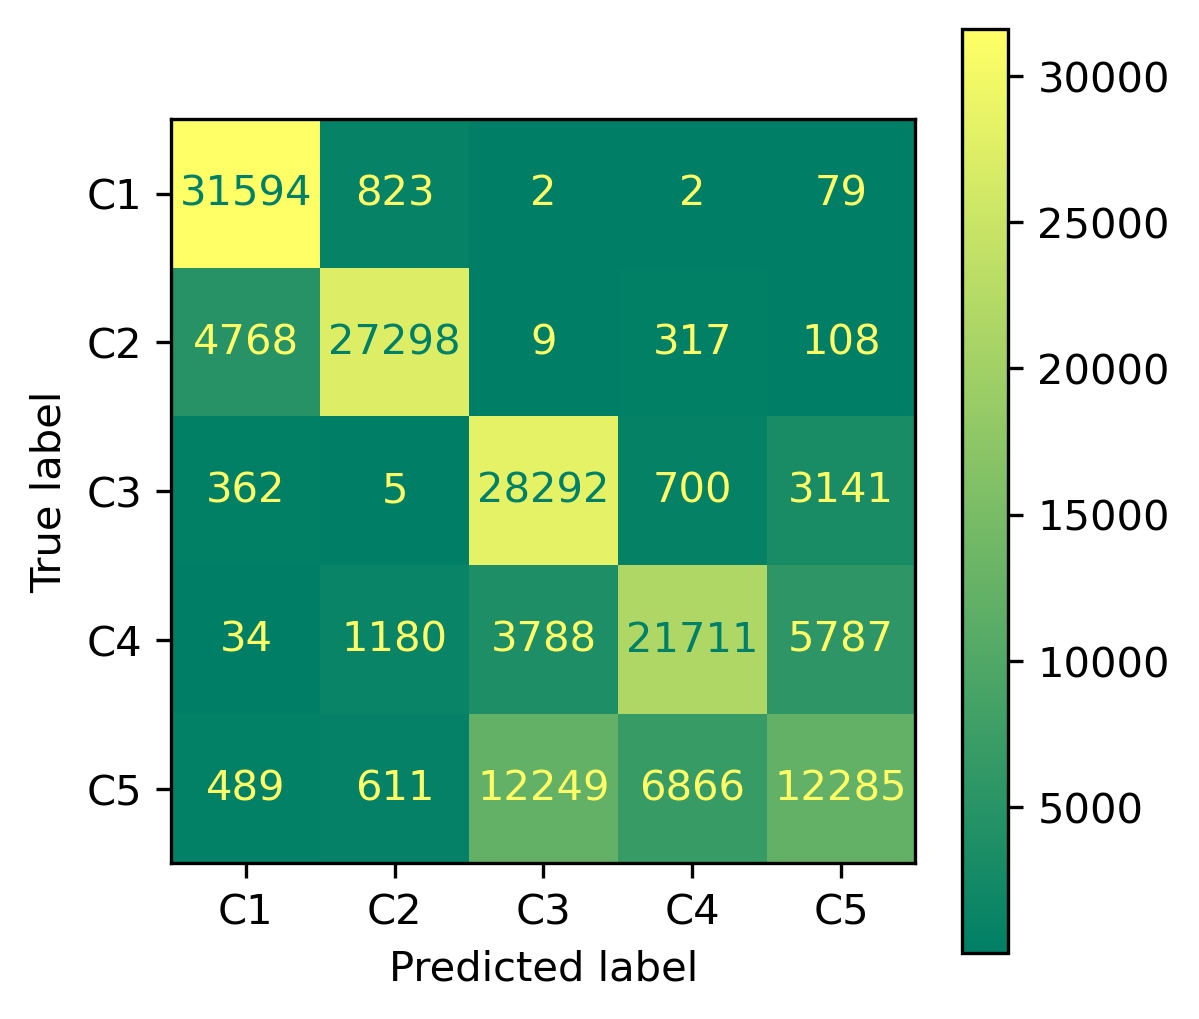

32500 32500 32500 32500 32500


In [5]:
# Load the trained model

model_to_load="Classification_models/EIS_33k_5circuit_v2_model_Classification_drop07_batch_256/model_228_0.56_0.75.h5"

#predict
predict_model = tf.keras.models.load_model(model_to_load)

x_t= x_test
y_t= y_test

m_ev=predict_model.evaluate(x_t,y_t)
y_pred=predict_model.predict(x_t)
y_pred_class = np.zeros(len(y_t))
y_test_class = np.zeros(len(y_t))

for idx in range(len(y_t)):

    y_pred_class[idx]=np.argmax(y_pred[idx])

test_list2=y_pred_class
    
for idx in range(len(y_t)):

    y_test_class[idx]=np.argmax(y_t[idx])

test_list1=y_test_class
        
cm=confusion_matrix(test_list1,test_list2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["C1","C2"
                              ,"C3","C4","C5"])
px = 1/plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(400*px, 400*px),dpi=300)
disp.plot(cmap="summer",ax=ax)
cfmc_title="Accuracy :"+str(m_ev[1]*100)+"%"+"\n"+"Loss :"+str(m_ev[0])
print(cfmc_title)
# plt.title(cfmc_title)
#plt.savefig("")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.show()

c1,c2,c3,c4,c5=0,0,0,0,0
for idx in range(len(test_list1)):
    if test_list1[idx]==0:c1=c1+1
    if test_list1[idx]==1:c2=c2+1    
    if test_list1[idx]==2:c3=c3+1  
    if test_list1[idx]==3:c4=c4+1
    if test_list1[idx]==4:c5=c5+1   
print(c1,c2,c3,c4,c5)

# ROC result

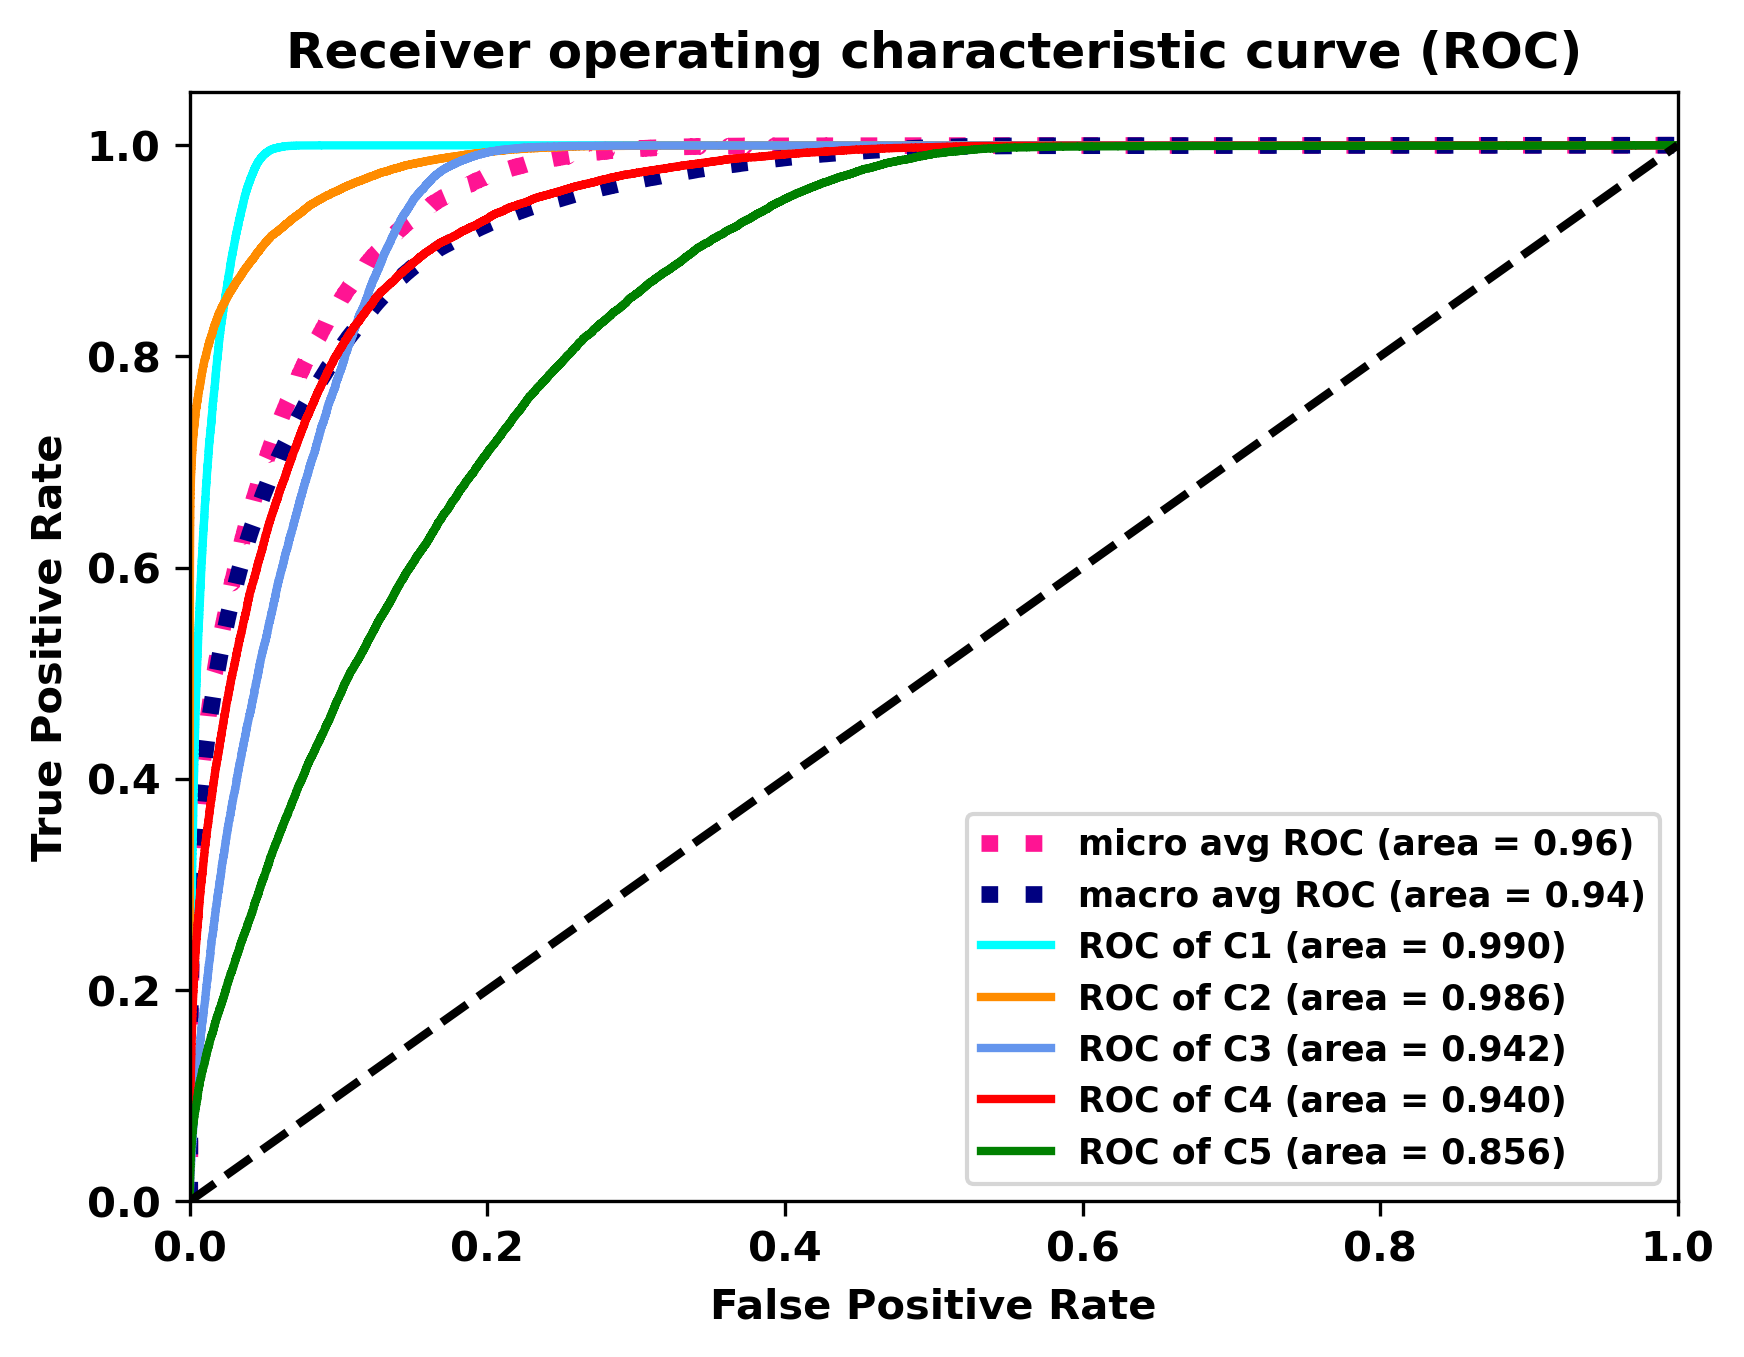

In [6]:
n_classes=n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(dpi=300)
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro avg ROC (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro avg ROC (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue","red","green"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC of C{0} (area = {1:0.3f})".format(i+1, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve (ROC)",fontweight="bold")
plt.legend(loc="lower right",fontsize="small")
plt.show()

In [ ]:
# Dulyawat Doonyapisut Email: charting9@gmail.com